In [51]:
# Data Processing
import pandas as pd
import numpy as np
 
# Modelling
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import randint
 
# in Termoinal do these installs
# pip install graphviz
# conda install grphviz

In [52]:
# Tree Visualisation
from sklearn.tree import export_graphviz
from IPython.display import Image
import graphviz

In [53]:
cin = pd.read_csv('https://raw.githubusercontent.com/data-to-insight/D2I-Jupyter-Notebook-Tools/refs/heads/main/ml-data%20science%20tutorials/data/CINdetails.csv')
characteristics = pd.read_csv('https://raw.githubusercontent.com/data-to-insight/D2I-Jupyter-Notebook-Tools/refs/heads/main/ml-data%20science%20tutorials/data/ChildCharacteristics.csv')
identifiers = pd.read_csv('https://raw.githubusercontent.com/data-to-insight/D2I-Jupyter-Notebook-Tools/refs/heads/main/ml-data%20science%20tutorials/data/ChildIdentifiers.csv')

In [54]:
print(cin.info())
print(identifiers.info())
print(characteristics.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101 entries, 0 to 100
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Unnamed: 0        101 non-null    int64 
 1   LAchildID         101 non-null    object
 2   CINdetailsID      101 non-null    int64 
 3   CINreferralDate   101 non-null    object
 4   ReferralSource    101 non-null    object
 5   PrimaryNeedCode   101 non-null    object
 6   CINclosureDate    63 non-null     object
 7   ReasonForClosure  63 non-null     object
 8   DateOfInitialCPC  85 non-null     object
 9   ReferralNFA       101 non-null    bool  
dtypes: bool(1), int64(2), object(7)
memory usage: 7.3+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 332 entries, 0 to 331
Data columns (total 9 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Unnamed: 0               332 non-null    int64  
 1   LAchildI

In [55]:
cin.sort_values('CINreferralDate', inplace=True, ascending=False)
cin.drop_duplicates('LAchildID', inplace=True, keep='first')
 
cin['CINplan'] = 1
 
cin

,Unnamed: 0,LAchildID,CINdetailsID,CINreferralDate,ReferralSource,PrimaryNeedCode,CINclosureDate,ReasonForClosure,DateOfInitialCPC,ReferralNFA,CINplan
36,36,RND000098194912,1,31/08/2012,7,N6,03/03/2014,RC2,21/10/2012,False,1
89,89,RND000333386932,1,30/12/2019,2A,N7,NaN,NaN,14/02/2020,False,1
71,71,RND000467290394,1,30/09/2013,5C,N0,05/02/2020,RC7,27/10/2013,False,1
8,8,RND000471630058,2,30/06/2022,6,N6,NaN,NaN,12/07/2022,False,1
46,46,RND000789331304,1,30/04/2018,7,N4,25/11/2018,RC6,16/07/2018,False,1
...,...,...,...,...,...,...,...,...,...,...,...
65,65,RND000469602476,1,03/07/2016,3C,N3,NaN,NaN,NaN,False,1
6,6,RND000382171815,1,02/04/2021,2A,N3,23/06/2021,RC3,02/04/2021,False,1
70,70,RND000235844862,1,01/11/2014,2A,N2,NaN,NaN,26/01/2015,False,1
55,55,RND000702784676,1,01/09/2017,1A,N2,NaN,NaN,27/11/2017,False,1


In [56]:
df = characteristics.merge(identifiers, how='left', on='LAchildID')
df = df.merge(cin, how='left', on='LAchildID')

df['Age'] = pd.to_datetime('today') - pd.to_datetime(df['PersonBirthDate'], format='%Y-%m-%d')
 
df['Age'] = df['Age']/pd.Timedelta(days=365)
 
cols_to_keep = ['Age', 'Ethnicity', 'GenderCurrent', 'CINplan']
 
df = df[cols_to_keep]
 
df

,Age,Ethnicity,GenderCurrent,CINplan
0,4.834502,WIRT,1,1.0
1,13.450940,WROM,9,1.0
2,7.335872,AOTH,1,1.0
3,10.012584,MWBC,0,1.0
4,5.031762,APKN,2,1.0
...,...,...,...,...
327,14.256420,WOTH,2,NaN
328,6.146830,WROM,2,NaN
329,2.823543,BCRB,1,NaN
330,11.209844,AIND,2,NaN


In [57]:
df['CINplan'] = df['CINplan'].fillna(0)
 
df

,Age,Ethnicity,GenderCurrent,CINplan
0,4.834502,WIRT,1,1.0
1,13.450940,WROM,9,1.0
2,7.335872,AOTH,1,1.0
3,10.012584,MWBC,0,1.0
4,5.031762,APKN,2,1.0
...,...,...,...,...
327,14.256420,WOTH,2,0.0
328,6.146830,WROM,2,0.0
329,2.823543,BCRB,1,0.0
330,11.209844,AIND,2,0.0


In [58]:
gender_dict = {1:'male',
               2:'female',
               0:'other',
               9:'other'}
 
df['GenderCurrent'] = df['GenderCurrent'].map(gender_dict)
 
df

,Age,Ethnicity,GenderCurrent,CINplan
0,4.834502,WIRT,male,1.0
1,13.450940,WROM,other,1.0
2,7.335872,AOTH,male,1.0
3,10.012584,MWBC,other,1.0
4,5.031762,APKN,female,1.0
...,...,...,...,...
327,14.256420,WOTH,female,0.0
328,6.146830,WROM,female,0.0
329,2.823543,BCRB,male,0.0
330,11.209844,AIND,female,0.0


In [59]:
def ethnic_check(row):
    letter = row[0]
    if letter == 'W':
        return 'white'
    if letter == 'B':
        return 'black'
    if (letter == 'A') | (letter == 'C'):
        return 'asian'
    if letter == 'M':
        return 'Mixed'
    else:
        return 'other'
 
 
df['Ethnicity'] = df['Ethnicity'].apply(ethnic_check)
 
df

,Age,Ethnicity,GenderCurrent,CINplan
0,4.834502,white,male,1.0
1,13.450940,white,other,1.0
2,7.335872,asian,male,1.0
3,10.012584,Mixed,other,1.0
4,5.031762,asian,female,1.0
...,...,...,...,...
327,14.256420,white,female,0.0
328,6.146830,white,female,0.0
329,2.823543,black,male,0.0
330,11.209844,asian,female,0.0


In [60]:
df_encoded = pd.get_dummies(df[['GenderCurrent', 'Ethnicity']])
 
full_df = df[['Age', 'CINplan']].merge(df_encoded, how='left', left_index=True, right_index=True)
 
full_df

,Age,CINplan,GenderCurrent_female,GenderCurrent_male,GenderCurrent_other,Ethnicity_Mixed,Ethnicity_asian,Ethnicity_black,Ethnicity_other,Ethnicity_white
0,4.834502,1.0,False,True,False,False,False,False,False,True
1,13.450940,1.0,False,False,True,False,False,False,False,True
2,7.335872,1.0,False,True,False,False,True,False,False,False
3,10.012584,1.0,False,False,True,True,False,False,False,False
4,5.031762,1.0,True,False,False,False,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...
327,14.256420,0.0,True,False,False,False,False,False,False,True
328,6.146830,0.0,True,False,False,False,False,False,False,True
329,2.823543,0.0,False,True,False,False,False,True,False,False
330,11.209844,0.0,True,False,False,False,True,False,False,False


In [61]:
# split data into features and label
X = full_df.drop('CINplan', axis=1)
y = full_df['CINplan']
 
# split data into train/test splits
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
 
# instantiate object for model
rf = RandomForestClassifier()
 
# fit model
rf.fit(X_train, y_train)
 
# make predictions
y_pred = rf.predict(X_test)
 
# check accuracy
print(accuracy_score(y_test, y_pred))

0.6716417910447762


In [62]:
tree = rf.estimators_[0]
 
dot_data = export_graphviz(tree,
                           feature_names=X_train.columns,
                           filled=True,
                           max_depth=3)
graph = graphviz.Source(dot_data)
display(graph)

ExecutableNotFound: failed to execute PosixPath('dot'), make sure the Graphviz executables are on your systems' PATH

In [63]:
for i in range(3):
    tree = rf.estimators_[i]
 
    dot_data = export_graphviz(tree,
                            feature_names=X_train.columns,
                            filled=True,
                            max_depth=3)
    graph = graphviz.Source(dot_data)
    display(graph)

ExecutableNotFound: failed to execute PosixPath('dot'), make sure the Graphviz executables are on your systems' PATH

ExecutableNotFound: failed to execute PosixPath('dot'), make sure the Graphviz executables are on your systems' PATH

ExecutableNotFound: failed to execute PosixPath('dot'), make sure the Graphviz executables are on your systems' PATH

In [64]:
new_rf = RandomForestClassifier()
 
rand_search = RandomizedSearchCV(new_rf,
                                 param_distributions={'n_estimators':randint(50,500),
                                                      'max_depth':randint(1,20)},
                                                      n_iter=10)
 
rand_search.fit(X_train, y_train)
 
print(rand_search.best_params_)
 
best_rf = rand_search.best_estimator_

{'max_depth': 3, 'n_estimators': 159}


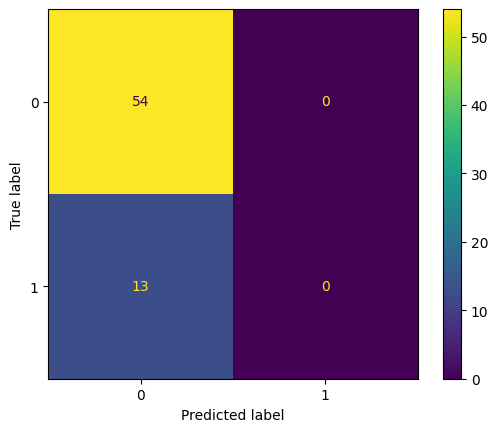

In [65]:
y_pred = best_rf.predict(X_test)
 
cm = confusion_matrix(y_test, y_pred)
 
ConfusionMatrixDisplay(confusion_matrix=cm).plot()

<Axes: xlabel='feature'>

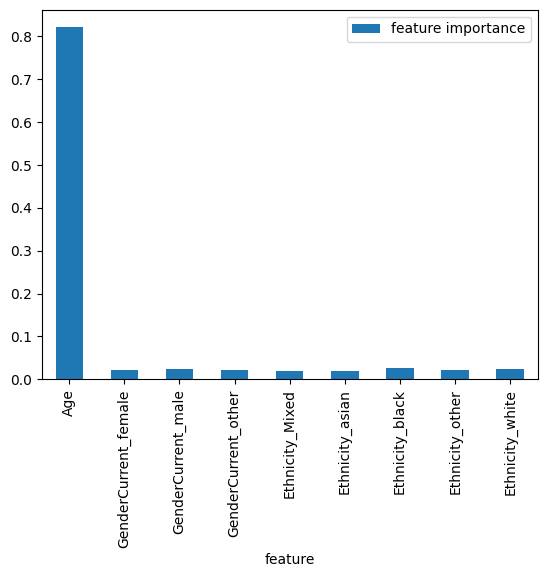

In [66]:
feature_importance_df = pd.DataFrame({'feature importance': rf.feature_importances_,
                                      'feature':X_train.columns})\
                                      .set_index('feature')
 
feature_importance_df.plot.bar()